<a href="https://colab.research.google.com/github/240609/MLF/blob/main/Project/Kopie_se%C5%A1itu_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJEKT**

#0. Import needed libraries

In [260]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data preprocessing
## 1.1 Importing data




In [261]:
print(os.listdir('/content/drive/MyDrive/MLF'))


['test_format.csv', 'label_train.csv', 'Train', 'Test', 'my_guess.csv', 'LetsCompete.csv']


In [262]:
# Set the path to your data
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/MLF'


# Load the CSV files
label_train = pd.read_csv(os.path.join(data_path, 'label_train.csv'))
test_format = pd.read_csv(os.path.join(data_path, 'test_format.csv'))

# Load all NPY files from the Train directory
train_data = []
for i in range(1491):  # Assuming files are named from 0.npy to 1490.npy
    file_path = os.path.join(data_path, 'Train', f'{i}.npy')
    if os.path.exists(file_path):
        data = np.load(file_path)
        train_data.append(data)

# Convert list to a NumPy array
train_data = np.array(train_data)

# Load all NPY files from the Test directory
test_data = []
for i in range(120):  # Assuming files are named from 0.npy to 119.npy
    file_path = os.path.join(data_path, 'Test', f'{i}.npy')
    if os.path.exists(file_path):
        data = np.load(file_path)
        test_data.append(data)

# Convert list to a NumPy array
test_data = np.array(test_data)

# Display the shapes of the loaded data
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train data shape: (1491, 72, 48)
Test data shape: (120, 72, 48)


In [263]:
print(train_data[0])
print(test_data[0])
print(label_train)
print(test_format)

[[-42.94846208 -34.19988488 -30.69119585 ... -43.47883062 -31.54647995
  -45.9194625 ]
 [-41.86518571 -34.80668569 -41.2543513  ... -43.86449976 -30.51855427
  -42.34268155]
 [-44.17245767 -30.68308296 -46.65993373 ... -31.69508203 -35.44104458
  -52.93088205]
 ...
 [-54.30841153 -34.66132862 -34.0509651  ... -43.77111016 -22.20773064
  -33.01597406]
 [-57.27087524 -22.44226418 -40.00710921 ... -35.46174065 -32.99610352
  -40.59258701]
 [-49.27546527 -32.22061918 -31.86473242 ... -31.3190966  -36.97273765
  -36.31152144]]
[[-11.25314668 -31.84428476 -22.68082809 ... -22.52479543 -32.91363933
  -29.65546479]
 [-21.6004675  -37.93874162 -19.49501801 ... -24.53372017 -25.91555421
  -33.29106494]
 [-12.72565979 -19.45708105 -24.2567116  ... -24.55794644 -26.70381511
  -34.58798993]
 ...
 [-20.83848579 -20.17628113 -27.87154065 ... -13.50993688 -23.19541761
  -30.58345256]
 [  0.5148323  -22.00535833 -18.17926808 ... -20.55218552 -28.46280408
  -26.58848488]
 [-19.46380877 -18.83375454 -19.

##1.2 Preprocesing data

In [264]:
def data_augment(dataset: np.array, labels: np.array, awgn_std: float = 3.0) -> tuple:

    # Rozdělíme data do tří tříd
    bts0 = dataset[labels == 0]
    bts1 = dataset[labels == 1]
    bts2 = dataset[labels == 2]

    # Zjistíme počet vzorků pro každou třídu
    count0, count1, count2 = bts0.shape[0], bts1.shape[0], bts2.shape[0]
    target = max(count0, count1, count2)  # Cílový počet vzorků pro každou třídu

    # Funkce pro syntézu vzorků
    def synthesize(data, target_count):
        n = data.shape[0]
        diff = target_count - n  # Kolik syntetických vzorků doplníme
        synthetic = []

        for _ in range(diff):
            idx = np.random.randint(n)  # Náhodný výběr existujícího vzorku
            sample = data[idx]
            noise = np.random.normal(0, awgn_std, size=sample.shape)
            synthetic.append(sample + noise)
        if synthetic:
            synthetic = np.array(synthetic)
            return np.concatenate([data, synthetic], axis=0)
        else:
            return data

    # Augmentace pro každou třídu
    new_bts0 = synthesize(bts0, target)
    new_bts1 = synthesize(bts1, target)
    new_bts2 = synthesize(bts2, target)

    # Spojíme všechna data dohromady a vytvoříme příslušné štítky
    final_data = np.concatenate([new_bts0, new_bts1, new_bts2], axis=0)
    final_labels = np.concatenate([
        np.full(new_bts0.shape[0], 0, dtype=labels.dtype),
        np.full(new_bts1.shape[0], 1, dtype=labels.dtype),
        np.full(new_bts2.shape[0], 2, dtype=labels.dtype)
    ], axis=0)

    return final_data, final_labels

In [265]:
y_label = label_train["target"].values  # Extrahujeme správný sloupec
y_test_label = test_format["target"].values   # Testovací štítky
train_data, y_label = data_augment(train_data,y_label,3)

# Rozdělení dat s rovnoměrným zastoupením tříd
X_train, X_test, y_train, y_test = train_test_split(
    train_data,
    y_label,
    test_size=0.2,
    random_state=42,
)

print(y_label)
print(y_test_label)

[0 0 0 ... 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [266]:
# Přetvarujeme data tak, aby každý vzorek byl jedním řádkem (3456 = 72*48)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)
test_data_scaled = scaler.transform(test_data_reshaped)

# Vracíme data zpět do původního 2D tvaru
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)
test_data_scaled = test_data_scaled.reshape(test_data.shape)


print(test_data_scaled.shape)
print(X_train_scaled.shape)
print(X_test_scaled.shape)



(120, 72, 48)
(2901, 72, 48)
(726, 72, 48)


In [267]:
X_train_final = X_train_scaled[..., np.newaxis]  # tvar (1491, 72, 48, 1)
X_test_final = X_test_scaled[..., np.newaxis]

In [268]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

print(y_train_encoded.shape)
print(y_test_encoded.shape)
#print(y_train_encoded[10:20])
#print(y_test_encoded[50:60])

(2901, 3)
(726, 3)


#2. Model Selection and Implementation

In [269]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(72, 48, 1), padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dropout(0.4),  # Tento ponechej
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])


model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 72, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 36, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │     3,539,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,539,779 (13.50 MB)

 Trainable params: 3,539,779 (13.50 MB)

 Non-trainable params: 0 (0.00 B)

#3. Model Training

In [270]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_final, y_train_encoded,
                    validation_data=(X_test_final, y_test_encoded),
                    epochs=20,
                    batch_size=32,
                    callbacks=[early_stop]
                    )

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8104 - loss: 0.4574 - val_accuracy: 0.9848 - val_loss: 0.0566
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9933 - loss: 0.0382 - val_accuracy: 0.9972 - val_loss: 0.0144
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9986 - val_loss: 0.0090
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss

#4. Model Evaluation

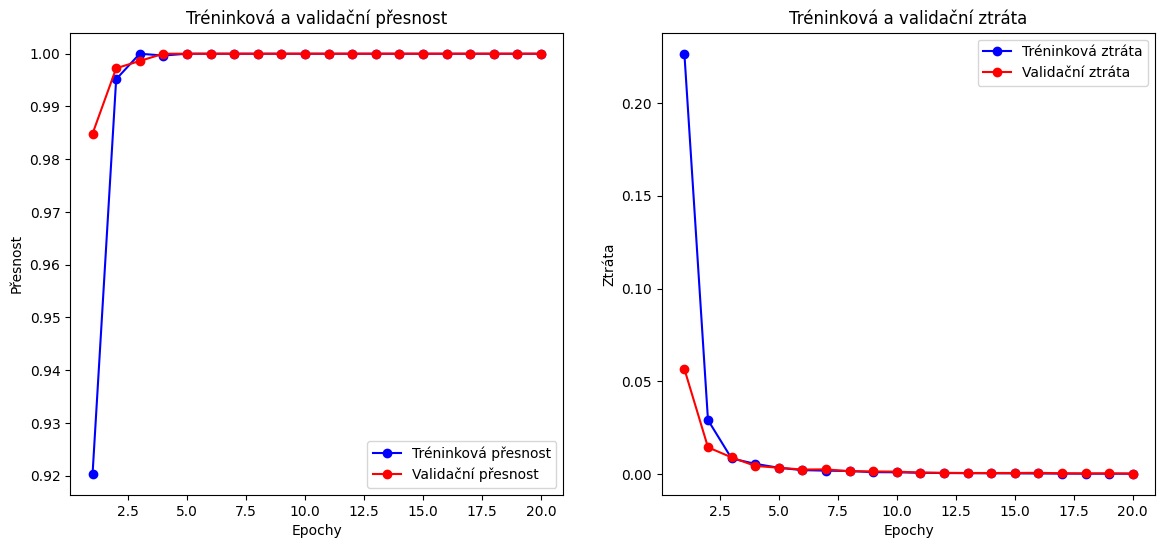

In [271]:
# Získání metrik z objektu history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Počet epoch
epochs = range(1, len(acc) + 1)

# Vykreslení přesnosti
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Tréninková přesnost')
plt.plot(epochs, val_acc, 'ro-', label='Validační přesnost')
plt.title('Tréninková a validační přesnost')
plt.xlabel('Epochy')
plt.ylabel('Přesnost')
plt.legend()

# Vykreslení ztráty
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Tréninková ztráta')
plt.plot(epochs, val_loss, 'ro-', label='Validační ztráta')
plt.title('Tréninková a validační ztráta')
plt.xlabel('Epochy')
plt.ylabel('Ztráta')
plt.legend()

plt.show()

#5. Conclusion



23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


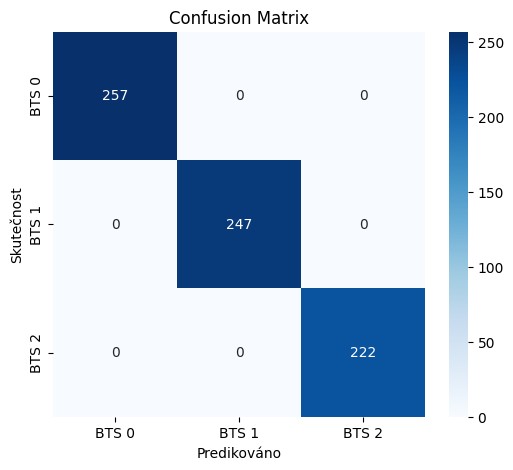

In [272]:
# Predikce pro validační data
y_pred = model.predict(X_test_final)

# Převedeme predikce i ground-truth zpět na třídy (0, 1, 2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Vytvoření matice záměn
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Vykreslení
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['BTS 0', 'BTS 1', 'BTS 2'],
            yticklabels=['BTS 0', 'BTS 1', 'BTS 2'])
plt.xlabel('Predikováno')
plt.ylabel('Skutečnost')
plt.title('Confusion Matrix')
plt.show()

#6. Saving data

In [273]:
test_data_final = test_data_scaled[..., np.newaxis]  # přidá kanál: (120, 72, 48, 1)
print(test_data_final.shape)  # ověř: (120, 72, 48, 1)

pred = model.predict(test_data_final)

array_to_save = np.vstack((np.arange(0, 119 + 1), np.argmax(pred, axis=1)))
#np.savetxt("my_guess.csv", array_to_save.transpose(),"%d", ",", header="ID,target", comments="")
np.savetxt("/content/drive/MyDrive/MLF/LetsCompete1.csv", array_to_save.transpose(), "%d", ",", header="ID,target", comments="")

(120, 72, 48, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
